# CV_S7 Segmentation

This notebook demonstrates image segmentation using classical clustering approaches and a pre-trained deep learning model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
import skfuzzy as fuzz
import torch
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50

# Load a sample image
image = data.astronaut()
image = image.astype(np.float32) / 255.0
print(f"Loaded image shape: {image.shape}")


Loaded image shape: (512, 512, 3)


## Original Image

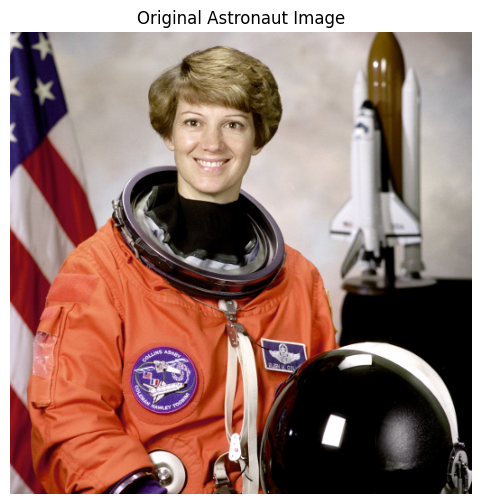

In [2]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
ax.axis("off")
ax.set_title("Original Astronaut Image")
plt.show()

## Threshold Segmentation

We convert the image to grayscale and apply Otsu's threshold to produce a binary mask highlighting foreground regions.


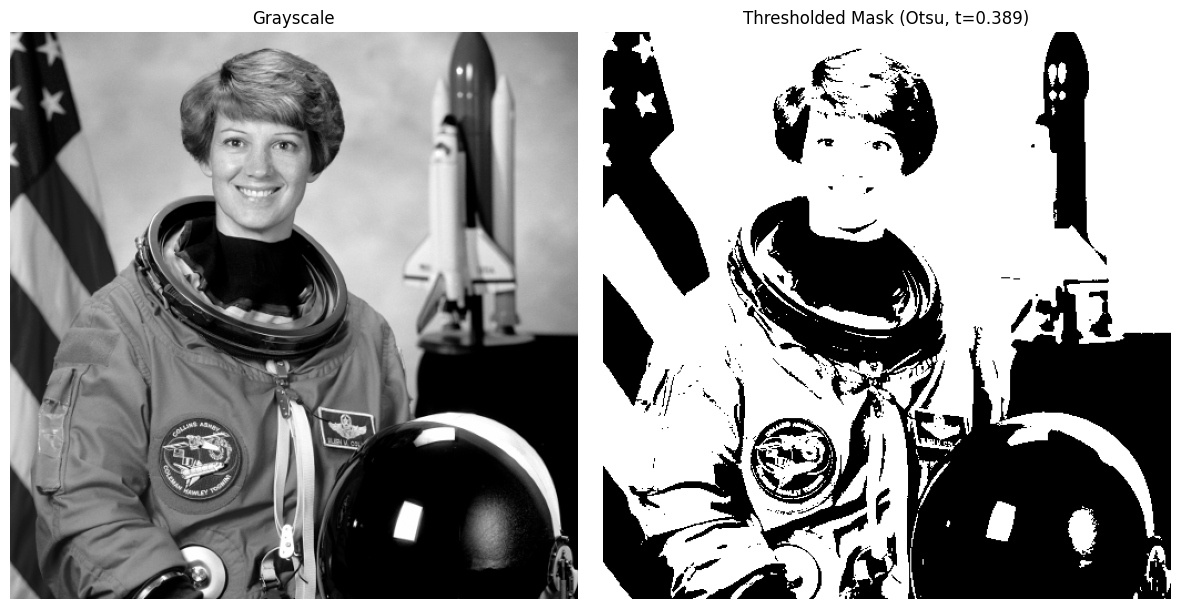

In [3]:
gray = rgb2gray(image)
threshold_value = threshold_otsu(gray)
binary_mask = gray > threshold_value

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(gray, cmap='gray')
axes[0].set_title("Grayscale")
axes[0].axis("off")

axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title(f"Thresholded Mask (Otsu, t={threshold_value:.3f})")
axes[1].axis("off")

plt.tight_layout()
plt.show()


## K-means Clustering

We reshape the pixels into a 2D array and run k-means to assign each pixel to one of the color clusters.

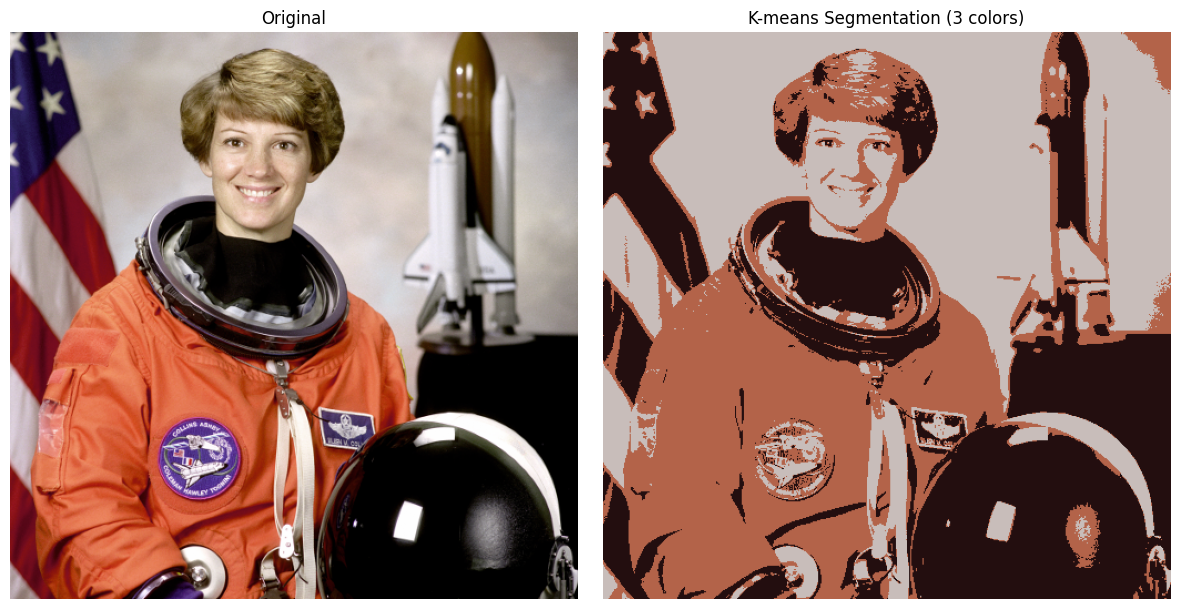

In [9]:
# Flatten the image for clustering
pixels = image.reshape(-1, 3)
n_cls =3
kmeans = KMeans(n_clusters=n_cls, random_state=42, n_init=10)
labels = kmeans.fit_predict(pixels)
clustered = kmeans.cluster_centers_[labels].reshape(image.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(clustered)
axes[1].set_title(f"K-means Segmentation ({n_cls} colors)")
axes[1].axis("off")
plt.tight_layout()
plt.show()

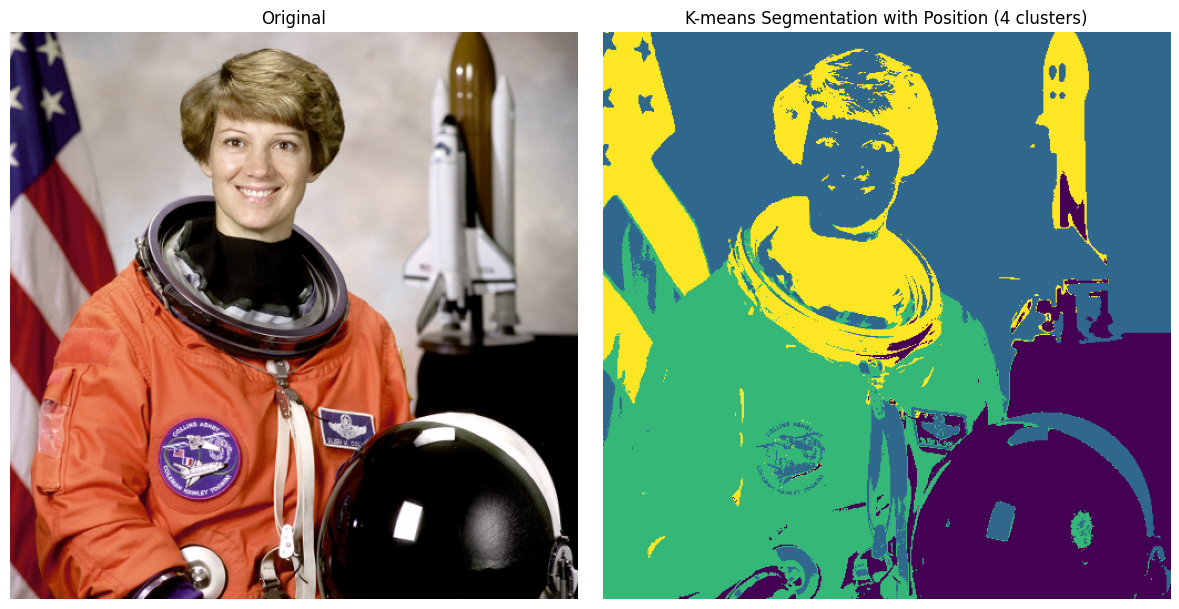

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

h, w, c = image.shape

# Create coordinate grid
x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))
x_coords = x_coords.reshape(-1, 1)
y_coords = y_coords.reshape(-1, 1)

# Flatten RGB values
pixels = image.reshape(-1, 3)

# Combine RGB + spatial features
features = np.hstack([pixels, x_coords, y_coords])

# Scale features so color and position contribute fairly
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

n_cls = 4
kmeans = KMeans(n_clusters=n_cls, random_state=42, n_init=10)
labels = kmeans.fit_predict(features_scaled)

# Reconstruct segmented image using RGB cluster centers
clustered = kmeans.cluster_centers_[labels][:, :3]
clustered = clustered.reshape(image.shape)
label_image = labels.reshape(h, w)


# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(label_image)
axes[1].set_title(f"K-means Segmentation with Position ({n_cls} clusters)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


## Fuzzy C-means Clustering

Fuzzy c-means assigns membership probabilities to clusters, allowing smoother transitions than hard k-means.

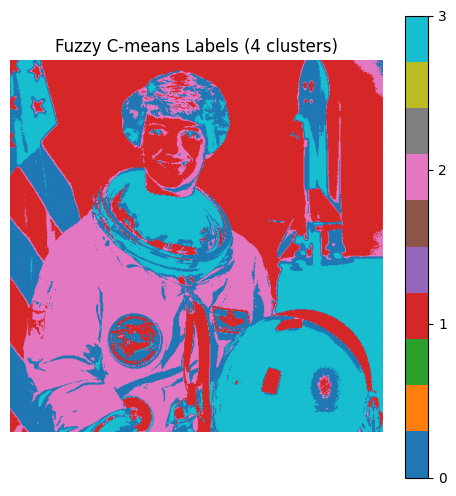

In [16]:
# skfuzzy expects data with shape (features, samples)
# Subsample pixels for efficiency
num_samples = 20000
rng = np.random.default_rng(0)
sample_indices = rng.choice(pixels.shape[0], size=num_samples, replace=False)
sampled_pixels = pixels[sample_indices]
fuzzy_data = sampled_pixels.T

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    fuzzy_data, c=4, m=2, error=0.005, maxiter=1000, init=None, seed=42
)

# Predict full-resolution memberships
full_data = pixels.T
u_full, _, _, _, _, _ = fuzz.cluster.cmeans_predict(full_data, cntr, m=2, error=0.005, maxiter=1000)
fuzzy_labels = np.argmax(u_full, axis=0)
fuzzy_segmented = cntr[fuzzy_labels].T.reshape(image.shape)

# Reshape labels to image
label_image = fuzzy_labels.reshape(image.shape[0], image.shape[1])

plt.figure(figsize=(6, 6))
plt.imshow(label_image, cmap="tab10")
plt.title("Fuzzy C-means Labels (4 clusters)")
plt.axis("off")
plt.colorbar(ticks=range(4))
plt.show()


## Deep Learning Segmentation (DeepLabV3)

A pre-trained DeepLabV3 model (trained on COCO) provides semantic segmentation. We map the predicted class labels to a color palette to visualize regions.

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /home/alirje/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100.0%


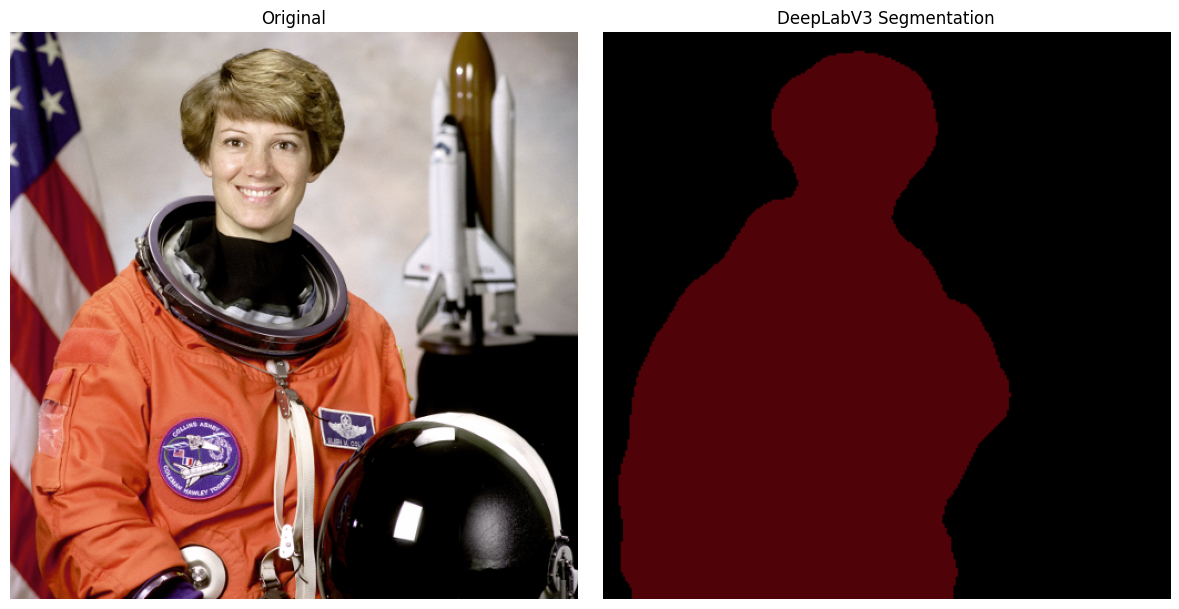

In [3]:
# Prepare the model and transforms
model = deeplabv3_resnet50(weights="DEFAULT")
model.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    output = model(input_batch)["out"][0]

pred_labels = output.argmax(0).cpu().numpy()

# Build a simple color palette
num_classes = output.shape[0]
rng = np.random.default_rng(123)
palette = rng.random((num_classes, 3))
palette[0] = 0  # background black
seg_map = palette[pred_labels]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(transforms.ToPILImage()(image))
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(seg_map)
axes[1].set_title("DeepLabV3 Segmentation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [4]:
from deepface import DeepFace
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

result = DeepFace.verify(img1_path = "face1.png", img2_path = "face2.png")



AttributeError: module 'deepface.modules.modeling' has no attribute 'build_model'